# Load Libraries

In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

!pip install tensorflow_transform
#!pip install tensorflow_datasets

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_transform as transforms

     |████████████████████████████████| 427 kB 5.1 MB/s 
     |████████████████████████████████| 10.1 MB 64.4 MB/s 
     |████████████████████████████████| 23.6 MB 1.4 MB/s 
     |████████████████████████████████| 19.1 MB 665 kB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 45 kB 3.4 MB/s 
     |████████████████████████████████| 2.3 MB 43.6 MB/s 
     |████████████████████████████████| 508 kB 76.0 MB/s 
     |████████████████████████████████| 245 kB 69.4 MB/s 
     |████████████████████████████████| 151 kB 66.9 MB/s 
     |████████████████████████████████| 83 kB 1.7 MB/s 
     |████████████████████████████████| 267 kB 63.5 MB/s 
     |████████████████████████████████| 111 kB 72.2 MB/s 
     |████████████████████████████████| 219 kB 58.5 MB/s 
     |████████████████████████████████| 173 kB 50.0 MB/s 
     |████████████████████████████████| 255 kB 51.1 MB/s 
     |████████████████████████████████| 180 kB 60.7 MB/s 
     |██████████████

In [ ]:
from tensorflow.python.keras.utils.vis_utils import plot_model

# Enabling & Testing TPU

In [ ]:
# %tensorflow_version 2.x
# import tensorflow as tf
# print("Tensorflow version " + tf.__version__)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# Setup GPU

## Enable Testing with GPU

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Observe TensorFlow speedup on GPU relative to CPU

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.7078115299999865
GPU (s):
0.04594552400001817
GPU speedup over CPU: 80x


# Load & Inspect Dataset and Stats

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to tmp/cifar10/3.0.2.incomplete309ITP/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to tmp/cifar10/3.0.2.incomplete309ITP/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to tmp/cifar10/3.0.2. Subsequent calls will reuse this data.
Raw train dataset: <PrefetchDataset shapes: ((32, 32, 3), ()), types: (tf.uint8, tf.int64)>
Raw train dataset size: 50000 

Raw test dataset: <PrefetchDataset shapes: ((32, 32, 3), ()), types: (tf.uint8, tf.int64)>
Raw test dataset size: 10000 



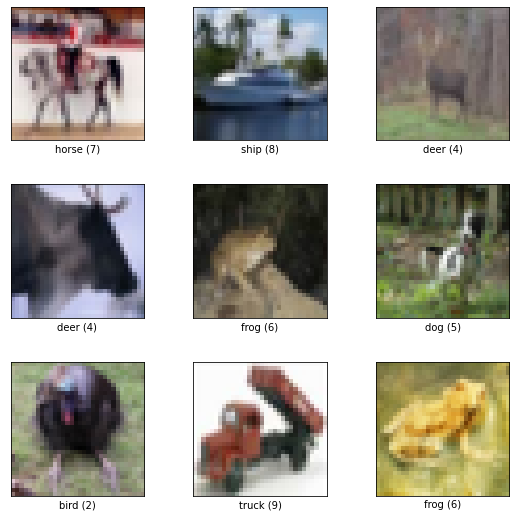

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)

In [ ]:
# DATASET_NAME = 'rock_paper_scissors'
DATASET_NAME = 'cifar10'

(dataset_train_raw, dataset_test_raw), dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir='tmp',
    with_info=True,
    as_supervised=True,
    split=[tfds.Split.TRAIN, tfds.Split.TEST],
)

print('Raw train dataset:', dataset_train_raw)
print('Raw train dataset size:', len(list(dataset_train_raw)), '\n')

print('Raw test dataset:', dataset_test_raw)
print('Raw test dataset size:', len(list(dataset_test_raw)), '\n')
fig = tfds.show_examples(dataset_train_raw, dataset_info)
dataset_info

In [ ]:
img_size=32


# MobileNetV1



```
# This is formatted as code
```

## Manish's Architecture


In [ ]:
def mobilenet_block(x, f, s=1):
    x = tf.keras.layers.DepthwiseConv2D(3, strides=s, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(f, 1, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x =tf.keras.layers.Activation('relu')(x)
    return x

In [ ]:

def mobileNet(input_shape, n_classes):
  """
  Manish's variation of MobileNetV1
  """
  
  def mobilenet_block(x, f, s=1):
    x = tf.keras.layers.DepthwiseConv2D(3, strides=s, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(f, 1, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x =tf.keras.layers.Activation('relu')(x)
    return x
    
    
  input = tf.keras.layers.Input(input_shape)

  x = tf.keras.layers.Conv2D(32, 3, strides=2, padding='same')(input)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  x = mobilenet_block(x, 64)
  x = mobilenet_block(x, 128)
  x = mobilenet_block(x, 128)

  x = mobilenet_block(x, 256)
  x = mobilenet_block(x, 256)

  x = mobilenet_block(x, 512)
  for _ in range(5):
    x = mobilenet_block(x, 512)

  x = mobilenet_block(x, 1024)
  x = mobilenet_block(x, 1024)
  
  x = tf.keras.layers.GlobalAvgPool2D()(x)
  # x = tf.keras.layers.AveragePooling2D()(x)
  
  output = tf.keras.layers.Dense(n_classes, activation='softmax')(x)
  
  model = tf.keras.models.Model(input, output)
  return model


# Aggregate and Reshape Train/Test Samples 

In [ ]:
x_train=[]
y_train=[]
for i,j in dataset_train_raw:
    x_train.append(i)
    y_train.append(j)
x_train=np.array(x_train).reshape(-1,img_size,img_size,3)
y_train=np.array(y_train).reshape((-1,1))

In [ ]:
x_train=x_train.astype('float32')
x_train/=255


In [ ]:

print(x_train.shape)

(50000, 32, 32, 3)


# CIFAR10: Train and Validate

In [ ]:
x_test=[]
y_test=[]
for i,j in dataset_test_raw:
    x_test.append(i)
    y_test.append(j)
x_test=np.array(x_test).reshape(-1,img_size,img_size,3)
y_test=np.array(y_test).reshape((-1,1))

In [ ]:
x_test=x_test.astype('float32')
x_test/=255


In [ ]:
print(y_test.shape)

(10000, 1)


In [ ]:
# input_shape=300,300,3
# n_classes=3
input_shape=32,32,3
n_classes=10

In [ ]:
model=mobileNet(input_shape, n_classes)

## Trial 1
Baseline of Manish's config
- Adam learning optimizer w/ lr=0.01
- Metric "acc"
- sparse_categorical_crossentropy


In [ ]:
# opt = SGD(lr=0.01)
model.compile( loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam( learning_rate=0.001 ) , metrics=[ 'acc' ] )

# bugfix ideas: https://stackoverflow.com/questions/37213388/keras-accuracy-does-not-change

# slow learning rate by a factor of 10
# model.compile( 
#     loss='sparse_categorical_crossentropy', 
#     optimizer=tf.keras.optimizers.Adam( learning_rate=0.001 ) , 
#     metrics=[ 'acc' ] )  

# slow lr by factor of 100 from Manish's
# model.compile( 
#     loss='sparse_categorical_crossentropy', 
#     optimizer=tf.keras.optimizers.Adam( learning_rate=0.0001 ) , 
#     metrics=[ 'acc' ] )  

# **Summary without HLAC (normal conv2d block)**

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 16, 16, 32)        0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 16, 16, 32)       320       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 32)       128   

In [ ]:
%timeit
model.fit(x_train,y_train,epochs=5,validation_data=(x_test,y_test),shuffle=True)

Epoch 1/5
1563/1563 [==============================] - 49s 27ms/step - loss: 1.8847 - acc: 0.3201 - val_loss: 1.6663 - val_acc: 0.3954
Epoch 2/5
1563/1563 [==============================] - 42s 27ms/step - loss: 1.5293 - acc: 0.4521 - val_loss: 1.7750 - val_acc: 0.4299
Epoch 3/5
1563/1563 [==============================] - 42s 27ms/step - loss: 1.3720 - acc: 0.5170 - val_loss: 3.0971 - val_acc: 0.4014
Epoch 4/5
1563/1563 [==============================] - 42s 27ms/step - loss: 1.2425 - acc: 0.5662 - val_loss: 1.4566 - val_acc: 0.5389
Epoch 5/5
1563/1563 [==============================] - 41s 26ms/step - loss: 1.1177 - acc: 0.6117 - val_loss: 1.1939 - val_acc: 0.6031


In [ ]:
# fan_in = height * width
img_size = 32 # 32 x 32
masks_origin = [
        "000010000",    # 0th order HLAC, 1 := 3 / sqrt(h*w), 0 := 3 / sqrt(h*w)
        "000011000",    # 1st order HLAC 
        "001010000",
        "010010000",
        "100010000",    
        
        "000111000",    # 2nd order HLAC 
        "001010100",
        "010010010",
        "100010001",
        "001110000",
        
        "010010100",
        "100010010",
        "000110001",
        "000011100",
        "001010010",
        
        "010010001",
        "100011000",
        "010110000",
        "100010100",
        "000110010",
        
        "000010101",
        "000011010",
        "001010001",
        "010011000",
        "101010000",
    ]
masks = []
masks_n = []
c = 0
# make masks
for mask_bin in masks_origin:
  # if c % 3 == 0:
    # m = []
  s = 0
  mask = []
  for ch in mask_bin:
    if c % 3 == 0:
      m = []
    if int(ch) == 1:
      s += 1
      m.append([3 / np.sqrt(img_size * img_size )])
    else:
      m.append([-3 /np.sqrt(img_size * img_size )])
    c+= 1
    if c % 3 == 0:
      mask.append([m])
  masks.append((mask))
  # reshaped = np.array(m).reshape((3, 3))
  print(mask_bin) # DEBUG
  print("{}th Order".format(s-1))
  print(mask,"\n") # DEBUG
masks = np.array(masks)
tf.constant(masks[0], dtype=tf.float32)
# mask_bin = np.array(mask_bin)
# mask_bin[0]
  # print(reshaped,"\n") # DEBUG
  # masks.append(.array(np.array(m).reshape((3, 3)))
  # masks_n.append(s)
masks[0]


000010000
0th Order
[[[[-0.09375], [-0.09375], [-0.09375]]], [[[-0.09375], [0.09375], [-0.09375]]], [[[-0.09375], [-0.09375], [-0.09375]]]] 

000011000
1th Order
[[[[-0.09375], [-0.09375], [-0.09375]]], [[[-0.09375], [0.09375], [0.09375]]], [[[-0.09375], [-0.09375], [-0.09375]]]] 

001010000
1th Order
[[[[-0.09375], [-0.09375], [0.09375]]], [[[-0.09375], [0.09375], [-0.09375]]], [[[-0.09375], [-0.09375], [-0.09375]]]] 

010010000
1th Order
[[[[-0.09375], [0.09375], [-0.09375]]], [[[-0.09375], [0.09375], [-0.09375]]], [[[-0.09375], [-0.09375], [-0.09375]]]] 

100010000
1th Order
[[[[0.09375], [-0.09375], [-0.09375]]], [[[-0.09375], [0.09375], [-0.09375]]], [[[-0.09375], [-0.09375], [-0.09375]]]] 

000111000
2th Order
[[[[-0.09375], [-0.09375], [-0.09375]]], [[[0.09375], [0.09375], [0.09375]]], [[[-0.09375], [-0.09375], [-0.09375]]]] 

001010100
2th Order
[[[[-0.09375], [-0.09375], [0.09375]]], [[[-0.09375], [0.09375], [-0.09375]]], [[[0.09375], [-0.09375], [-0.09375]]]] 

010010010
2th 

array([[[[-0.09375],
         [-0.09375],
         [-0.09375]]],


       [[[-0.09375],
         [ 0.09375],
         [-0.09375]]],


       [[[-0.09375],
         [-0.09375],
         [-0.09375]]]])

In [ ]:
m=tf.Variable(masks)

m=tf.cast(m,'float32')

m=tf.reshape(m,[25,3,1,3])




In [ ]:
input = tf.keras.layers.Input(input_shape)

#x = tf.keras.layers.Conv2D(32, 3, strides=2, padding='same')(input)
x=tf.nn.conv2d(input, m, strides=[1, 1], padding='SAME')
x.trainable=False
print(x.shape)
x = tf.keras.layers.Conv2D(7, 3, strides=2, padding='same')(x)


x = tf.keras.layers.BatchNormalization()(x)
output = tf.keras.layers.Activation('relu')(x)
model = tf.keras.models.Model(input, output)
model.compile( loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam( learning_rate=0.001 ) , metrics=[ 'acc' ] )
model.summary()

(None, 32, 32, 3)
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 tf.compat.v1.nn.conv2d_1 (T  (None, 32, 32, 3)        0         
 FOpLambda)                                                      
                                                                 
 conv2d_42 (Conv2D)          (None, 16, 16, 7)         196       
                                                                 
 batch_normalization_81 (Bat  (None, 16, 16, 7)        28        
 chNormalization)                                                
                                                                 
 activation_81 (Activation)  (None, 16, 16, 7)         0         
                                                                 
Total params: 224
Trainable params: 210
N

In [ ]:
#tf.keras.layers.Concatenate(axis=1)([x, y])
input = tf.keras.layers.Input(input_shape)

#x = tf.keras.layers.Conv2D(32, 3, strides=2, padding='same')(input)
x1=tf.nn.conv2d(input, m, strides=[1, 1], padding='SAME')
print(x1.shape)
x1.trainable=False
x=tf.keras.layers.Flatten()(x1)
x1=tf.reshape(x,(16,12,16))
x2= tf.keras.layers.Conv2D(7, 3, strides=2, padding='same')(input)
x=tf.keras.layers.Flatten()(x2)
x2=tf.reshape(x,(16,7,16))
print(x2.shape)
#print(x2.reshape(32,1,3))
x=tf.keras.layers.Concatenate(axis=1)([x1, x2])
#x=tf.keras.layers.Add()([x1,x2])
x = tf.keras.layers.BatchNormalization()(x1)
output = tf.keras.layers.Activation('relu')(x)
model = tf.keras.models.Model(input, output)
model.compile( loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam( learning_rate=0.001 ) , metrics=[ 'acc' ] )
model.summary()

(None, 32, 32, 3)
(16, 7, 16)
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 tf.compat.v1.nn.conv2d_2 (T  (None, 32, 32, 3)        0         
 FOpLambda)                                                      
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 tf.reshape (TFOpLambda)     (16, 12, 16)              0         
                                                                 
 batch_normalization_82 (Bat  (16, 12, 16)             64        
 chNormalization)                                                
                                                                 
 activation_82 (Activation)  

In [ ]:

def predefined(input_shape, n_classes,m):
  """
  Manish's variation of MobileNetV1
  """
  
  def mobilenet_block(x, f, s=1):
    x = tf.keras.layers.DepthwiseConv2D(3, strides=s, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(f, 1, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x =tf.keras.layers.Activation('relu')(x)
    return x
    
    
  input = tf.keras.layers.Input(input_shape)

  #x = tf.keras.layers.Conv2D(32, 3, strides=2, padding='same')(input)
  x1=tf.nn.conv2d(input, m, strides=[1, 1], padding='SAME')
  print(x1.shape)
  x1.trainable=False
  x=tf.keras.layers.Flatten()(x1)
  x1=tf.reshape(x,(16,12,16))
  x2= tf.keras.layers.Conv2D(7, 3, strides=2, padding='same')(input)
  x=tf.keras.layers.Flatten()(x2)
  x2=tf.reshape(x,(16,7,16))
  print(x2.shape)
  #print(x2.reshape(32,1,3))
  x=tf.keras.layers.Concatenate(axis=1)([x1, x2])
  print(x.shape)
  x=tf.reshape(x,(-1,16,19,16))
  #x=tf.keras.layers.Add()([x1,x2])
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  x = mobilenet_block(x, 64)
  x = mobilenet_block(x, 128, 2)
  x = mobilenet_block(x, 128)

  x = mobilenet_block(x, 256, 2)
  x = mobilenet_block(x, 256)

  x = mobilenet_block(x, 512, 2)
  for _ in range(5):
    x = mobilenet_block(x, 512)

  x = mobilenet_block(x, 1024, 2)
  x = mobilenet_block(x, 1024)
  
  x = tf.keras.layers.GlobalAvgPool2D()(x)
  # x = tf.keras.layers.AveragePooling2D()(x)
  
  output = tf.keras.layers.Dense(n_classes, activation='softmax')(x)
  
  model = tf.keras.models.Model(input, output)
  return model


In [ ]:
model=predefined(input_shape, n_classes,m)
print(model.summary())

(None, 32, 32, 3)
(16, 7, 16)
(16, 19, 16)
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 tf.compat.v1.nn.conv2d_3 (TFOp  (None, 32, 32, 3)   0           ['input_7[0][0]']                
 Lambda)                                                                                          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 16, 16, 7)    196         ['input_7[0][0]']                
                                                                                                  
 flatten_2 (Flatten)            (None, 3072)     

In [ ]:
input = tf.keras.layers.Input(input_shape)

x = tf.keras.layers.Conv2D(33, 3, strides=2, padding='same')(input)
print(x.shape)
model = tf.keras.models.Model(input, x)

model.summary()



(None, 16, 16, 33)
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 16, 16, 33)        924       
Total params: 924
Trainable params: 924
Non-trainable params: 0
_________________________________________________________________


In [ ]:
input = tf.keras.layers.Input(input_shape)
x = tf.keras.layers.Conv2D(33, 3, strides=2,groups=3,padding='same')(input)
print(x.shape)
model=tf.keras.models.Model(input,x)
model.summary()

(None, 16, 16, 33)
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 16, 16, 33)        330       
Total params: 330
Trainable params: 330
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.python.keras.utils.vis_utils import plot_model


In [ ]:
seed=np.random.uniform(size=3,low=-1,high=1)
#seed=np.reshape(seed,(3,1,1))
seed=tf.convert_to_tensor(seed)

# Reducing pointwise multiplications

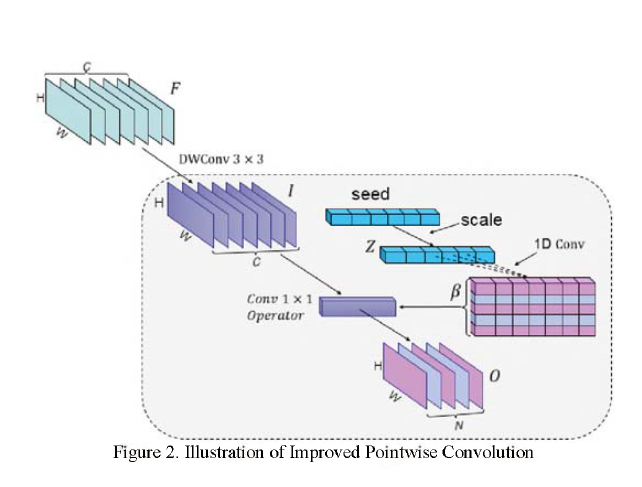

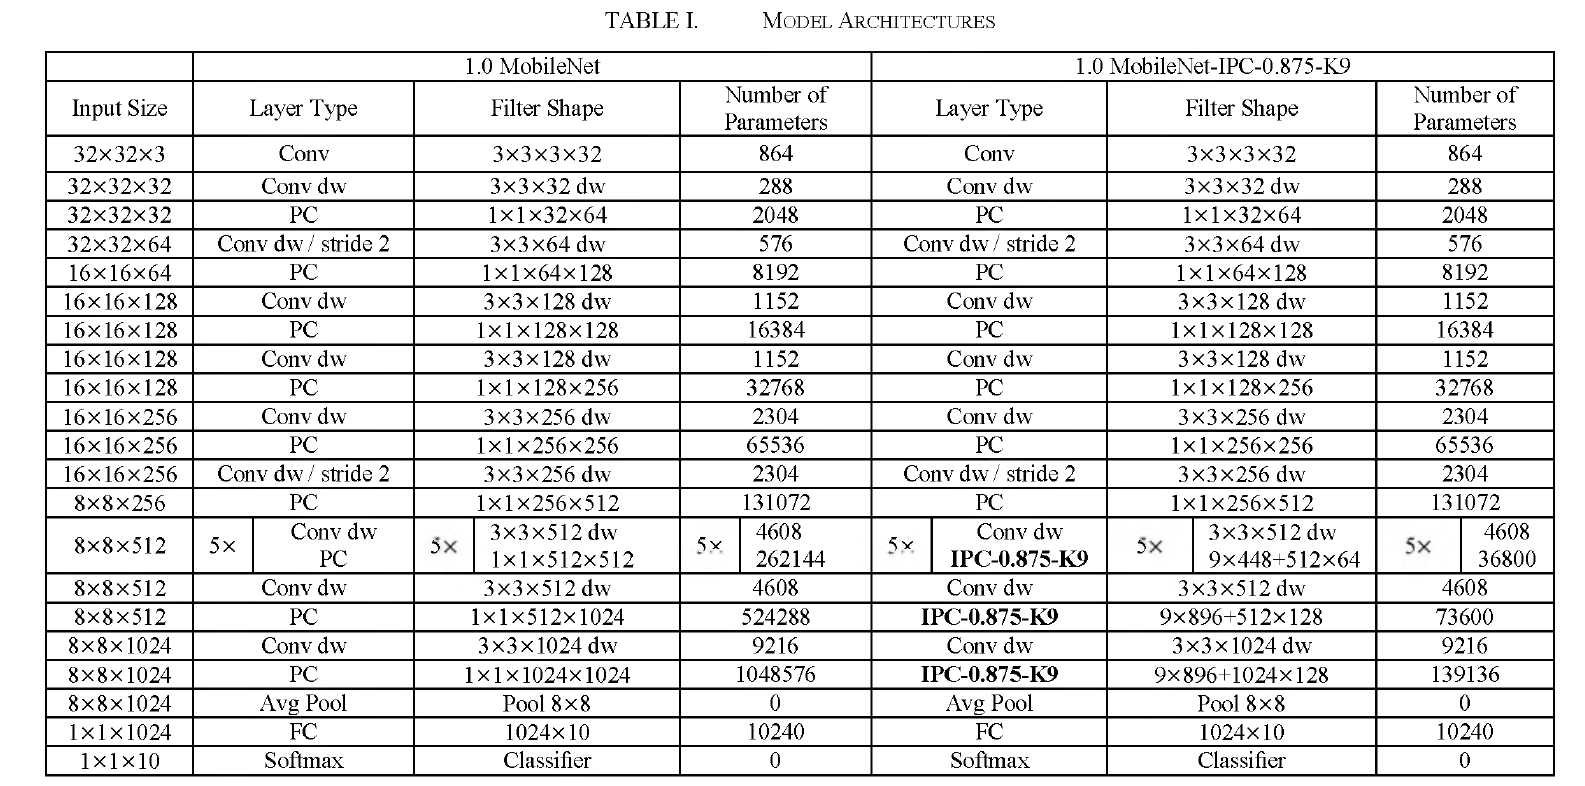

Other techniques
LU decompostion
LU reduction
Block LU decomposition
Rank factorization
Cholesky decomposition
QR decomposition
RRQR factorization

In [ ]:
def mobilenet_block(x, f, s=1):
    x = tf.keras.layers.DepthwiseConv2D(3, strides=s, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(f, 1, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x =tf.keras.layers.Activation('relu')(x)
    return x

# changing IPC

In [ ]:
class ScaleLayer(tf.keras.layers.Layer):
    def __init__(self, scale):
        super(ScaleLayer, self).__init__()
        self.scale = scale
    def call(self, inputs):
        return inputs * self.scale

In [ ]:
def IPC_block(input_shape, f,alpha,k):

    #depthwise convolution
    #x=tf.keras.layers.Conv2D(f,3,strides=1,padding='same')(input_shape)
    #input = tf.keras.layers.Input(input_shape)
    x1 = tf.keras.layers.DepthwiseConv2D(3, strides=1, padding='same')(input_shape)
    y=input.shape
    depth_shape=x1.shape
    channels=depth_shape[-1]
    x = tf.keras.layers.BatchNormalization()(x1)
    x = tf.keras.layers.Activation('relu')(x)
    print('depthwise shape',x.shape)
    #seed=np.random.uniform(size=y[-1],low=-1,high=1)
    #seed=np.reshape(seed,(y[-1],1,1))
    #seed=tf.convert_to_tensor(seed)
    #alpha=tf.cast(alpha,'float64')
    seed=tf.random.uniform(
    (1,x.shape[-1],1,1), minval=-1, maxval=0, dtype=tf.dtypes.float32, seed=None, name=None)
    print("the shape of seed",seed.shape)
    alpha=tf.reshape(alpha,(1,1,1))
    Z_i=tf.nn.conv1d(seed,alpha,stride=1,padding="SAME")
    beta=tf.keras.layers.Conv2D(32,k,strides=1,padding='same')(Z_i)
    print(beta.shape)

    # conv2d with k filters with (1-alpha)*f kernel size and with input z
    #beta=tf.keras.layers.Conv2D(k,kernel_size=[int((1-alpha)*f)+1,1], strides=1, padding='same')(seed)
    #w11,x11,y1,z1=beta.shape
    #print(beta.shape)
    #eta=tf.reshape(beta,(1,1,(w11*x11*y1*z1),1))
    #point wise conv2d with (1-alpha)*f filters and input x1
    # I and beta are point wise convoluted to get the output
    #O=tf.keras.layers.Conv2D()
    print("depth wise shape filter c",x.shape)
    print("beta shape input c",beta.shape)
    o=tf.nn.conv2d(beta,x,strides=1,padding='SAME')
    o=tf.keras.layers.BatchNormalization()(o)
    o=tf.keras.layers.Activation('relu')(o)
    return o

    """ 
    x2=tf.keras.layers.Conv2D(int((1-alpha)*f),1,strides=1,padding='same')(input)
    print(" point wise convolution with dimensions as channels in input and int(1-alpha)*f",x2.shape)
    w22,x12,y2,z2=x2.shape
    x2=tf.reshape(x2,(1,1,(x12*y2*z2),1))
    print(x2.shape)
    #new edit 2/2/22 
    y1 = tf.keras.layers.Concatenate(axis=2)([beta, x2])
    print(y1.shape)
    _,t1,t2,t3=y1.shape
    y1=tf.reshape(y1,(1,1,(t1*t2*t3)//32,32))
    print("after concatenating",y1.shape)
    x = tf.keras.layers.BatchNormalization()(y1)
    x =tf.keras.layers.Activation('relu')(x)
    return x
    """

In [ ]:
# input_shape=300,300,3
# n_classes=3
input_shape=(8,8,512)
#(2, 1, 512)
n_classes=10

In [ ]:
"""
input = tf.keras.layers.Input((1,1,3))
print(input.shape)
tf.random.uniform((1,input.shape[-1],1,1), minval=-1, maxval=0, dtype=tf.dtypes.float32, seed=None, name=None)
"""

'\ninput = tf.keras.layers.Input((1,1,3))\nprint(input.shape)\ntf.random.uniform((1,input.shape[-1],1,1), minval=-1, maxval=0, dtype=tf.dtypes.float32, seed=None, name=None)\n'

In [ ]:
input = tf.keras.layers.Input(input_shape)

In [ ]:
x = tf.keras.layers.DepthwiseConv2D(3, strides=1, padding='same')(input)
x.shape

In [ ]:
def IPC_block(input_shape, f,alpha,k):

  x1 = tf.keras.layers.DepthwiseConv2D(3, strides=1, padding='same')(input_shape)
  x = tf.keras.layers.BatchNormalization()(x1)
  x = tf.keras.layers.Activation('relu')(x)

##Main change comes here 
# setting the seed vector as the shape same as the channels size in depthwise convolution
  seed=tf.random.uniform(
  (1,x1.shape[-1],1,1), minval=-1, maxval=0, dtype=tf.dtypes.float32, seed=None, name=None)

## converting the alpha value into a 4 dimensions as it has to be the filter for the conv1d with the seed
  alpha=tf.reshape(alpha,(1,1,1))
## z is the result of 1d convolution between alpha and seed vector
  Z_i=tf.nn.conv1d(seed,alpha,stride=1,padding="SAME")
  print(f"the shape of z i.e scaled vector",Z_i.shape)
### beta is the total convolution between 
  beta=tf.keras.layers.Conv2D(k,x1.shape[-1],strides=1,padding='same')(Z_i)
  print("filter shape",x1.shape)
  print("input shape",beta.shape)


###edits 2/9/2022 9:59 pm
## no of filters 64 , size = 9, input shape= 1,512,9
  o1=tf.keras.layers.Conv2D(int(x1.shape[-1]*(1-alpha)),1,strides=1,padding='same')(beta) ## (1,512,1,64)#beta in place of Z_i
  print("2nd pointwise convolution ",o1.shape)
  o2=tf.keras.layers.Conv2D(k,int(x1.shape[-1]*(1-alpha)),strides=1,padding='valid')(beta) # beta in place of Z_i
  
  print(o2.shape)
  #new_output=tf.keras.layers.concatenate(axis=3)([o1,o2])
  new_output=tf.keras.layers.Concatenate()([o1, o2])
  print(new_output.shape)
  new_output=tf.keras.layers.BatchNormalization()(new_output)
  new_output=tf.keras.layers.Activation('relu')(new_output)
  return new_output


###edits 2/9/2022 9:59 pm
"""
  o=tf.nn.conv2d(beta,x1,strides=1,padding='SAME')
  o=tf.keras.layers.BatchNormalization()(o)
  o=tf.keras.layers.Activation('relu')(o)
"""
  



"\n  o=tf.nn.conv2d(beta,x1,strides=1,padding='SAME')\n  o=tf.keras.layers.BatchNormalization()(o)\n  o=tf.keras.layers.Activation('relu')(o)\n"

In [1]:
def IPC_block(input_shape, f,alpha,k):

  x1 = tf.keras.layers.DepthwiseConv2D(3, strides=1, padding='same')(input_shape)
  x = tf.keras.layers.BatchNormalization()(x1)
  x = tf.keras.layers.Activation('relu')(x)

##Main change comes here 
# setting the seed vector as the shape same as the channels size in depthwise convolution
  seed=tf.random.uniform(
  (1,x1.shape[-1],1,1), minval=-1, maxval=0, dtype=tf.dtypes.float32, seed=None, name=None)

## converting the alpha value into a 4 dimensions as it has to be the filter for the conv1d with the seed
  alpha=tf.reshape(alpha,(1,1,1))
## z is the result of 1d convolution between alpha and seed vector
  Z_i=tf.nn.conv1d(seed,alpha,stride=1,padding="SAME")
  print(f"the shape of z i.e scaled vector",Z_i.shape)
### beta is the total convolution between 
  beta=tf.keras.layers.Conv2D(k,x1.shape[-1],strides=1,padding='same')(Z_i)
  print("filter shape",x1.shape)
  print("input shape",beta.shape)


###edits 2/9/2022 9:59 pm
## no of filters 64 , size = 9, input shape= 1,512,9
  o1=tf.keras.layers.Conv2D(int(x1.shape[-1]*(1-alpha)),1,strides=1,padding='same')(beta) ## (1,512,1,64)#beta in place of Z_i
  print("2nd pointwise convolution ",o1.shape)
  o2=tf.keras.layers.Conv2D(k,int(x1.shape[-1]*(alpha)),strides=1,padding='same')(beta) # beta in place of Z_i
  ## interchange k,512
  
  print(o2.shape)
  #new_output=tf.keras.layers.concatenate(axis=3)([o1,o2])
  new_output=tf.keras.layers.Concatenate()([o1, o2])
  print(new_output.shape)
  new_output=tf.keras.layers.BatchNormalization()(new_output)
  new_output=tf.keras.layers.Activation('relu')(new_output)
  return new_output


###edits 2/9/2022 9:59 pm
"""
  o=tf.nn.conv2d(beta,x1,strides=1,padding='SAME')
  o=tf.keras.layers.BatchNormalization()(o)
  o=tf.keras.layers.Activation('relu')(o)
"""
  



"\n  o=tf.nn.conv2d(beta,x1,strides=1,padding='SAME')\n  o=tf.keras.layers.BatchNormalization()(o)\n  o=tf.keras.layers.Activation('relu')(o)\n"

In [6]:
512*(1-0.875)

64.0

In [3]:
# input_shape=300,300,3
# n_classes=3
input_shape=(8,8,512)
n_classes=10
input = tf.keras.layers.Input(input_shape)

out=IPC_block(input, f=512,alpha=0.875,k=9)

the shape of z i.e scaled vector (1, 512, 1, 1)
filter shape (None, 8, 8, 512)
input shape (1, 512, 1, 9)
2nd pointwise convolution  (1, 512, 1, 64)
(1, 512, 1, 9)
(1, 512, 1, 73)


In [4]:
model = tf.keras.models.Model(input, outputs=out)

ValueError: ignored

In [ ]:
model.summary()



Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 8, 8, 512)]       0         
                                                                 
 depthwise_conv2d_70 (Depthw  (None, 8, 8, 512)        5120      
 iseConv2D)                                                      
                                                                 
 tf.compat.v1.nn.conv2d_26 (  (1, 512, 1, 512)         0         
 TFOpLambda)                                                     
                                                                 
 batch_normalization_110 (Ba  (1, 512, 1, 512)         2048      
 tchNormalization)                                               
                                                                 
 activation_110 (Activation)  (1, 512, 1, 512)         0         
                                                          

checking parameters without improved pointwise convolutions

with input_size=

In [ ]:
x=tf.keras.layers.DepthwiseConv2D()

In [ ]:
def mobilenet_block(x, f, s=1):
    x = tf.keras.layers.DepthwiseConv2D(3, strides=s, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(f, 1, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x =tf.keras.layers.Activation('relu')(x)
    return x

In [ ]:
input = tf.keras.layers.Input(input_shape)
output= mobilenet_block(input, 512, s=1)
model = tf.keras.models.Model(input, output)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 8, 8, 512)]       0         
                                                                 
 depthwise_conv2d_21 (Depthw  (None, 8, 8, 512)        5120      
 iseConv2D)                                                      
                                                                 
 batch_normalization_32 (Bat  (None, 8, 8, 512)        2048      
 chNormalization)                                                
                                                                 
 activation_32 (Activation)  (None, 8, 8, 512)         0         
                                                                 
 conv2d_18 (Conv2D)          (None, 8, 8, 512)         262656    
                                                                 
 batch_normalization_33 (Bat  (None, 8, 8, 512)        2048

In [ ]:

def ManishNet(input_shape, n_classes):
  """
  Manish's variation of MobileNetV1
  """
  input = tf.keras.layers.Input(input_shape)
  x = tf.keras.layers.Conv2D(32, 3, strides=1, padding='same')(input)
  #print("conv2d --1",x.shape)
  x = tf.keras.layers.BatchNormalization()(x)
  #print("batchNormalzation",x.shape)
  x = tf.keras.layers.Activation('relu')(x)
  #print("activation",x.shape)
  x = mobilenet_block(x, 64)
  x = mobilenet_block(x, 64,2)
  #print("1st mobilenetblock_1",x.shape)
  x = mobilenet_block(x, 128, 1)
  #print("2nd mobilenetblock_2",x.shape)
  x = mobilenet_block(x, 128)
  #print("3rd mobilenetblock_3",x.shape)

  x = mobilenet_block(x, 256)
  #print("4th mobilenetblock_4",x.shape)
  x = mobilenet_block(x, 256,2)
  #print("5th mobilenet_block_5",x.shape)

  x = mobilenet_block(x, 512, 1)
  #print("6th mobilenetblock_6",x.shape)
  for i in range(5):
    x = IPC_block(x,512,alpha=0.875,k=9)
    #print(f"{i+7} Improvedblock shape {x.shape}")
    
  x = IPC_block(x, 512,alpha=0.875, k=9)
  #print("12 IPC",x.shape)
  x = IPC_block(x,1024,alpha=0.875,k=9)
  print("13 IPC",x.shape)
  
  x = tf.keras.layers.GlobalAvgPool2D()(x)
  # x = tf.keras.layers.AveragePooling2D()(x)
  
  output = tf.keras.layers.Dense(n_classes, activation='softmax')(x)
  print(output.shape)
  
  model = tf.keras.models.Model(input, output)
  return model


In [ ]:
# input_shape=300,300,3
# n_classes=3
input_shape=32,32,3
n_classes=10

In [ ]:
model=ManishNet(input_shape, n_classes)

depthwise shape (None, 8, 8, 512)
the shape of seed (1, 512, 1, 1)
(1, 512, 1, 32)
depth wise shape filter c (None, 8, 8, 512)
beta shape input c (1, 512, 1, 32)
depthwise shape (1, 512, 1, 512)
the shape of seed (1, 512, 1, 1)
(1, 512, 1, 32)
depth wise shape filter c (1, 512, 1, 512)
beta shape input c (1, 512, 1, 32)
depthwise shape (1, 512, 1, 512)
the shape of seed (1, 512, 1, 1)
(1, 512, 1, 32)
depth wise shape filter c (1, 512, 1, 512)
beta shape input c (1, 512, 1, 32)
depthwise shape (1, 512, 1, 512)
the shape of seed (1, 512, 1, 1)
(1, 512, 1, 32)
depth wise shape filter c (1, 512, 1, 512)
beta shape input c (1, 512, 1, 32)
depthwise shape (1, 512, 1, 512)
the shape of seed (1, 512, 1, 1)
(1, 512, 1, 32)
depth wise shape filter c (1, 512, 1, 512)
beta shape input c (1, 512, 1, 32)
depthwise shape (1, 512, 1, 512)
the shape of seed (1, 512, 1, 1)
(1, 512, 1, 32)
depth wise shape filter c (1, 512, 1, 512)
beta shape input c (1, 512, 1, 32)
depthwise shape (1, 512, 1, 512)
the s

In [ ]:
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_47 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 activation_47 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 depthwise_conv2d_38 (Depthw  (None, 32, 32, 32)       320       
 iseConv2D)                                                      
                                                                 
 batch_normalization_48 (Bat  (None, 32, 32, 32)       128

In [ ]:
model.compile( loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam( learning_rate=0.001 ) , metrics=[ 'acc' ] )

In [ ]:
model.fit(x_train,y_train,epochs=5,validation_data=(x_test,y_test),shuffle=True)

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


InvalidArgumentError: ignored

In [ ]:
def channel_shuffle(x):
    g = 2
    b, h, w, c = x.shape
    x = tf.reshape(x, [-1, h, w, g, c // g])
    x = tf.transpose(x, perm = [0, 1, 2, 4, 3])
    x = tf.reverse(x,[-1])
    x = tf.reshape(x, [-1, h, w, c])
    return x

In [ ]:
input = tf.keras.layers.Input(input_shape)
x = tf.keras.layers.Conv2D(3, 1, strides=1,padding='same')(input)
x=channel_shuffle(x)
x = tf.keras.layers.Conv2D(33, 3, strides=2,groups=3,padding='same')(x)
print(x.shape)
model=tf.keras.models.Model(input,x)
model.summary()

(None, 16, 16, 33)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 3)         12        
_________________________________________________________________
tf.reshape_2 (TFOpLambda)    (None, 32, 32, 2, 1)      0         
_________________________________________________________________
tf.compat.v1.transpose_1 (TF (None, 32, 32, 1, 2)      0         
_________________________________________________________________
tf.reverse_1 (TFOpLambda)    (None, 32, 32, 1, 2)      0         
_________________________________________________________________
tf.reshape_3 (TFOpLambda)    (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16

### Summary with Group convolutions

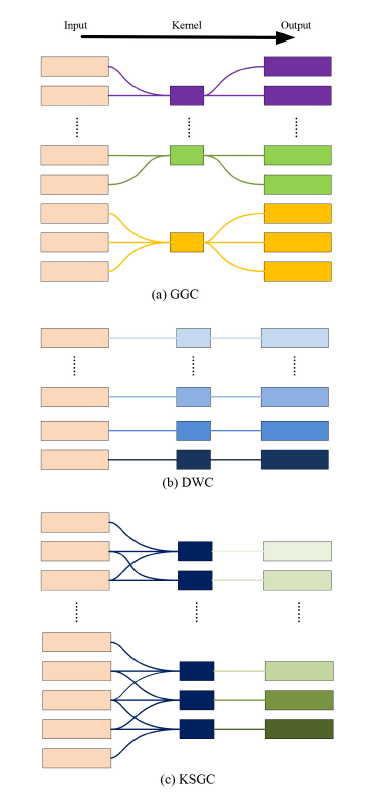

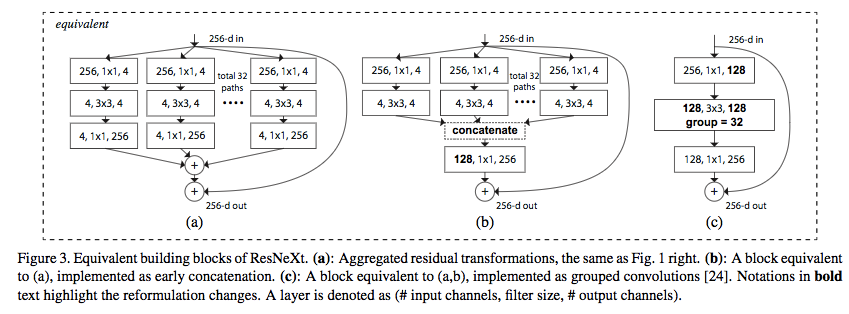

In [ ]:

def ManishNet(input_shape, n_classes):
  """
  Manish's variation of MobileNetV1
  """
  
  def mobilenet_block(x, f, s=1):
    x = tf.keras.layers.DepthwiseConv2D(3, strides=s, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(f, 1, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x =tf.keras.layers.Activation('relu')(x)
    return x
    
    
  input = tf.keras.layers.Input(input_shape)

  x = tf.keras.layers.Conv2D(33, 3, strides=2, padding='same',groups=3)(input)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  x = mobilenet_block(x, 64)
  x = mobilenet_block(x, 128, 2)
  x = mobilenet_block(x, 128)

  x = mobilenet_block(x, 256, 2)
  x = mobilenet_block(x, 256)

  x = mobilenet_block(x, 512, 2)
  for _ in range(5):
    x = mobilenet_block(x, 512)

  x = mobilenet_block(x, 1024, 2)
  x = mobilenet_block(x, 1024)
  
  x = tf.keras.layers.GlobalAvgPool2D()(x)
  # x = tf.keras.layers.AveragePooling2D()(x)
  
  output = tf.keras.layers.Dense(n_classes, activation='softmax')(x)
  
  model = tf.keras.models.Model(input, output)
  return model


In [ ]:
model=ManishNet(input_shape, n_classes)
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 16, 16, 33)        330       
_________________________________________________________________
batch_normalization_56 (Batc (None, 16, 16, 33)        132       
_________________________________________________________________
activation_56 (Activation)   (None, 16, 16, 33)        0         
_________________________________________________________________
depthwise_conv2d_26 (Depthwi (None, 16, 16, 33)        330       
_________________________________________________________________
batch_normalization_57 (Batc (None, 16, 16, 33)        132       
_________________________________________________________________
activation_57 (Activation)   (None, 16, 16, 33)        0   

In [ ]:
# opt = SGD(lr=0.01)
model.compile( loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam( learning_rate=0.001 ) , metrics=[ 'acc' ] )
model.fit(x_train,y_train,epochs=5,validation_data=(x_test,y_test),shuffle=True)

Epoch 1/5
1563/1563 [==============================] - 49s 29ms/step - loss: 1.8986 - acc: 0.3104 - val_loss: 1.8458 - val_acc: 0.4095
Epoch 2/5
1563/1563 [==============================] - 44s 28ms/step - loss: 1.5715 - acc: 0.4350 - val_loss: 1.5067 - val_acc: 0.4710
Epoch 3/5
1563/1563 [==============================] - 45s 29ms/step - loss: 1.4239 - acc: 0.4972 - val_loss: 1.5098 - val_acc: 0.4896
Epoch 4/5
1563/1563 [==============================] - 45s 29ms/step - loss: 1.2715 - acc: 0.5553 - val_loss: 1.3146 - val_acc: 0.5504
Epoch 5/5
1563/1563 [==============================] - 44s 28ms/step - loss: 1.1659 - acc: 0.5931 - val_loss: 1.5981 - val_acc: 0.5460


### Summary Shuffling group convolution

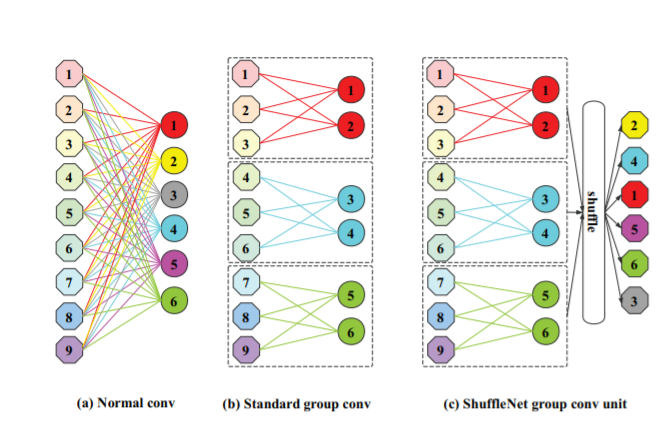

In [ ]:

def ManishNet(input_shape, n_classes):
  """
  Manish's variation of MobileNetV1
  """
  
  def mobilenet_block(x, f, s=1):
    x = tf.keras.layers.DepthwiseConv2D(3, strides=s, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(f, 1, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x =tf.keras.layers.Activation('relu')(x)
    return x
    
    
  input = tf.keras.layers.Input(input_shape)

  x = tf.keras.layers.Conv2D(3, 1, strides=1,padding='same')(input)
  x=channel_shuffle(x)
  x = tf.keras.layers.Conv2D(33, 3, strides=2,groups=3,padding='same')(x)
  x=channel_shuffle(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  x = mobilenet_block(x, 64)
  x = mobilenet_block(x, 128, 2)
  x = mobilenet_block(x, 128)

  x = mobilenet_block(x, 256, 2)
  x = mobilenet_block(x, 256)

  x = mobilenet_block(x, 512, 2)
  for _ in range(5):
    x = mobilenet_block(x, 512)

  x = mobilenet_block(x, 1024, 2)
  x = mobilenet_block(x, 1024)
  
  x = tf.keras.layers.GlobalAvgPool2D()(x)
  # x = tf.keras.layers.AveragePooling2D()(x)
  
  output = tf.keras.layers.Dense(n_classes, activation='softmax')(x)
  
  model = tf.keras.models.Model(input, output)
  return model


In [ ]:
model=ManishNet(input_shape, n_classes)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 3)         12        
_________________________________________________________________
tf.reshape_4 (TFOpLambda)    (None, 32, 32, 2, 1)      0         
_________________________________________________________________
tf.compat.v1.transpose_2 (TF (None, 32, 32, 1, 2)      0         
_________________________________________________________________
tf.reverse_2 (TFOpLambda)    (None, 32, 32, 1, 2)      0         
_________________________________________________________________
tf.reshape_5 (TFOpLambda)    (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 33)        330 

In [ ]:
# opt = SGD(lr=0.01)
model.compile( loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam( learning_rate=0.001 ) , metrics=[ 'acc' ] )
model.fit(x_train,y_train,epochs=5,validation_data=(x_test,y_test),shuffle=True)

Epoch 1/5
1563/1563 [==============================] - 79s 28ms/step - loss: 1.9318 - acc: 0.2969 - val_loss: 1.6744 - val_acc: 0.3796
Epoch 2/5
1563/1563 [==============================] - 43s 28ms/step - loss: 1.5948 - acc: 0.4309 - val_loss: 9.7642 - val_acc: 0.2940
Epoch 3/5
1563/1563 [==============================] - 43s 27ms/step - loss: 1.4469 - acc: 0.4903 - val_loss: 1.3882 - val_acc: 0.5158
Epoch 4/5
1563/1563 [==============================] - 43s 27ms/step - loss: 1.2891 - acc: 0.5511 - val_loss: 1.5225 - val_acc: 0.4905
Epoch 5/5
1563/1563 [==============================] - 42s 27ms/step - loss: 1.2151 - acc: 0.5801 - val_loss: 1.2519 - val_acc: 0.5758


In [ ]:
%timeit
model.compile( loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam( learning_rate=0.001 ) , metrics=[ 'acc' ] )


# Summary with Predefined weights(only 25 kernels) with 0 parameters

In [ ]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 16, 16, 33)        330       
_________________________________________________________________
batch_normalization_56 (Batc (None, 16, 16, 33)        132       
_________________________________________________________________
activation_56 (Activation)   (None, 16, 16, 33)        0         
_________________________________________________________________
depthwise_conv2d_26 (Depthwi (None, 16, 16, 33)        330       
_________________________________________________________________
batch_normalization_57 (Batc (None, 16, 16, 33)        132       
_________________________________________________________________
activation_57 (Activation)   (None, 16, 16, 33)        0   

In [ ]:
model.fit(x_train,y_train,epochs=5,validation_data=(x_test,y_test),shuffle=True)

Epoch 1/5
1563/1563 [==============================] - 49s 29ms/step - loss: 1.0714 - acc: 0.6328 - val_loss: 1.1670 - val_acc: 0.6071
Epoch 2/5
1563/1563 [==============================] - 44s 28ms/step - loss: 0.9396 - acc: 0.6755 - val_loss: 1.0585 - val_acc: 0.6354
Epoch 3/5
1563/1563 [==============================] - 44s 28ms/step - loss: 0.8640 - acc: 0.7033 - val_loss: 0.9325 - val_acc: 0.6779
Epoch 4/5
1563/1563 [==============================] - 44s 28ms/step - loss: 0.7633 - acc: 0.7375 - val_loss: 0.9238 - val_acc: 0.6889
Epoch 5/5
1563/1563 [==============================] - 45s 29ms/step - loss: 0.7330 - acc: 0.7500 - val_loss: 0.8989 - val_acc: 0.6939


# Kernel sharing between two convolutions

In [ ]:
i=(1,2,3)

In [ ]:
i[-1]

3

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.python.keras.utils.vis_utils import plot_model

In [ ]:
input_shape=(32,32,3)
input = tf.keras.layers.Input(input_shape)

In [ ]:
def my_conv_2d(input, weight_shape, num_filters, strides): 
    my_weights = tf.get_variable(name="weights", shape=weight_shape)
    my_bias = tf.get_variable(name="bias", shape=num_filters) 
    my_conv = tf.nn.conv2d(input, my_weights, strides=strides, padding='same', name='conv_layer1')
    my_conv = tf.nn.bias_add(my_conv, my_bias)
    conv_layer_out = tf.nn.relu(my_conv)
    return conv_layer_out

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,857
Trainable params: 1,857
Non-trainable params: 0
_________________________________________________________________


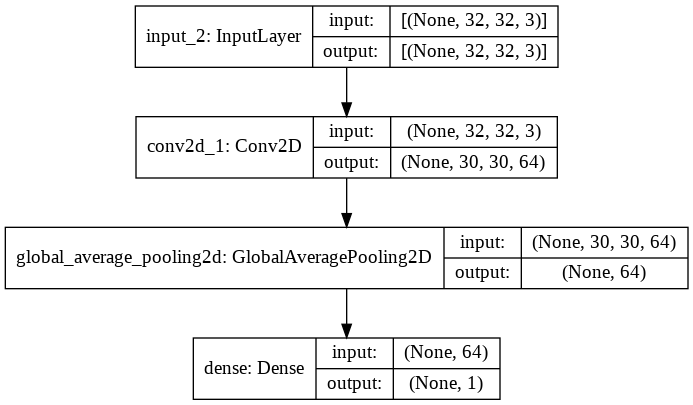

In [ ]:
input = tf.keras.layers.Input(input_shape)
conv1 = tf.keras.layers.Conv2D(64, 3, padding='same')(input)
conv2 =tf.keras.layers.Conv2D(64, 3, padding='valid')(input)
x=tf.keras.layers.GlobalAveragePooling2D()(conv2)
output=tf.keras.layers.Dense(1)(x)
model=tf.keras.models.Model(input,output)
model.compile(loss='binary_crossentropy', optimizer='adam')
model.summary()
plot_model(model,show_shapes=True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 64)   1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 64)   1792        input_3[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 32, 32, 128)  0           conv2d_2[0][0]                   
                                                                 conv2d_3[0][0]             

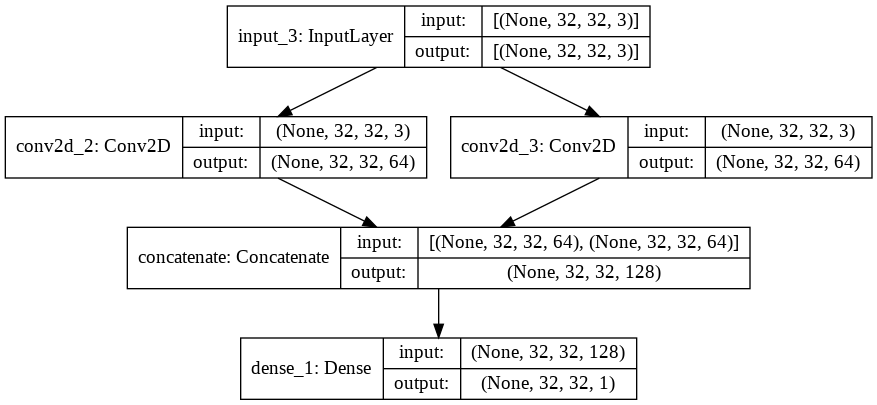

In [ ]:
input = tf.keras.layers.Input(input_shape)
conv1 = tf.keras.layers.Conv2D(64, 3, padding='same')(input)
conv2 =tf.keras.layers.Conv2D(64, 3, padding='same')(input)
x=tf.keras.layers.GlobalAveragePooling2D()(conv2)
x=tf.keras.layers.GlobalAveragePooling2D()(conv1)
merge=tf.keras.layers.concatenate([conv1,conv2])
output=tf.keras.layers.Dense(1)(merge)
model=tf.keras.models.Model(input,output)
model.compile(loss='binary_crossentropy', optimizer='adam')
model.summary()
plot_model(model,show_shapes=True)

1
Both the weights of the convolutions are same True
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 66)   1848        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 66)   1848        input_4[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 32, 32, 132)  0           conv2d_6[0][0]                   
                                       

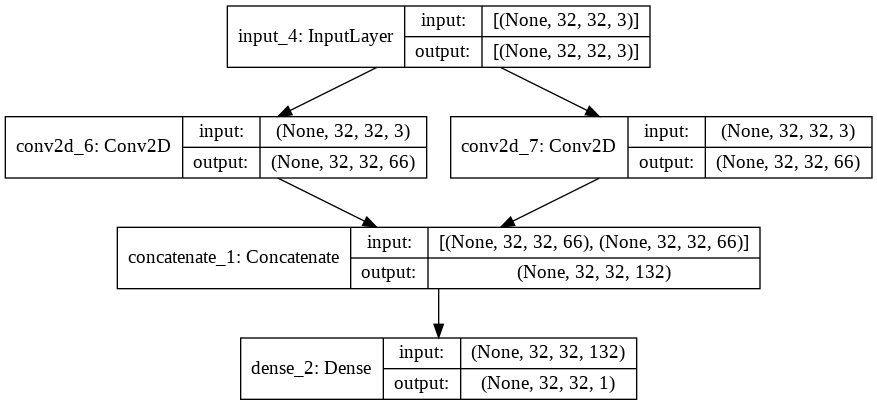

In [ ]:
def create_shared_weights(conv1, conv2, input_shape):
    with tf.name_scope(conv1.name):
        conv1.build(input_shape)
    with tf.name_scope(conv2.name):
        conv2.build(input_shape)
    print(conv1.groups)
    conv2.kernel = conv1.kernel
    conv2.bias = conv1.bias
    conv2._trainable_weights = []
    conv2._trainable_weights.append(conv2.kernel)
    conv2._trainable_weights.append(conv2.bias)

# check if weights are successfully shared
#input_img = Input(shape=(299, 299, 3))
input_shape=(32,32,3)
conv1 = tf.keras.layers.Conv2D(66, 3, padding='same')
conv2 =tf.keras.layers.Conv2D(66, 3, padding='valid')
create_shared_weights(conv1, conv2, input_shape=input_shape)
print(f"Both the weights of the convolutions are same {conv2.weights == conv1.weights}")  # True

input = tf.keras.layers.Input(input_shape)
conv1 = tf.keras.layers.Conv2D(66, 3, padding='same')(input)
conv2 =tf.keras.layers.Conv2D(66, 3, padding='same')(input)
x=tf.keras.layers.GlobalAveragePooling2D()(conv2)
x=tf.keras.layers.GlobalAveragePooling2D()(conv1)
merge=tf.keras.layers.concatenate([conv1,conv2])
output=tf.keras.layers.Dense(1)(merge)
model=tf.keras.models.Model(input,output)
model.compile(loss='binary_crossentropy', optimizer='adam')
model.summary()
plot_model(model,show_shapes=True)

# check if weights are equal after model fitting
#left = conv1(input)
#right = conv2(left)
#left = tf.keras.layers.GlobalAveragePooling2D()(left)
#right = tf.keras.layers.GlobalAveragePooling2D()(right)
#merged = tf.keras.layers.concatenate([left, right])
#output =tf.keras.layers. Dense(1)(right)
#model = tf.keras.models.Model(input, output)
#model.compile(loss='binary_crossentropy', optimizer='adam')

#model.summary()

# custom kernels in a custom conv2d

Inital Kernel
$$\begin{bmatrix} A &B &C &D &E \\ F &G &H &I &J \\ K &L& M& N&  O \\ P &Q &R &S &T \\ U &V &W &X &Y \end{bmatrix}$$

25 kernels

Custom Kernel

$$\begin{bmatrix} A &A &B &C &C \\ A &A &B &C &C \\ D &D& E& F&  F \\ G &G &H &I &I \\ G &G &H &I &I\end{bmatrix}$$

9 kernels but (5,5) still 25


https://stackoverflow.com/questions/54093950/how-to-experiment-with-custom-2d-convolution-kernels-in-keras

https://stackoverflow.com/questions/66003585/creating-custom-conv2d-layer-in-keras-with-several-hard-coded-filters

In [ ]:
input_shape=(32,32,3)

In [ ]:
(5,5)+(3,64)

(5, 5, 3, 64)

In [ ]:
class CustomConv2D(tf.keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        self.filters = filters
        self.kernel_size = (5, 5)
        
        super(CustomConv2D, self).__init__(**kwargs)

    def build(self, input_shape):
        # only have a 3x3 kernel
        shape = self.kernel_size + (input_shape[-1], self.filters)
        self.kernel = self.add_weight(name='kernel', shape=shape,
                                     initializer='glorot_uniform',trainable=False)
        super(CustomConv2D, self).build(input_shape)
        
        # Make sure self.filters is divisible by self.groups
        #input_shape=tf.cast(input_shape,tf.int32)
        #kernel_shape = self.kernel_size + (input_shape // self.groups, self.filters // self.groups)
        # Filters for a single group
        #self.kernel_base = self.add_weight(
         #   name='kernel',
          #  shape=kernel_shape,
           # initializer='glorot_uniform')
        # Tile filters for the rest of groups
        #self.kernel = tf.tile(self.kernel_base, [1, 1, 1, self.groups])
        super(CustomConv2D, self).build(input_shape)

    def call(self, x):
        # duplicate rows 0 and 2
        dup_rows = tf.stack([self.kernel[0]]*2 +[self.kernel[1]]+ [self.kernel[2]]*2, axis=0)
        # duplicate cols 0 and 2
        dup_cols = tf.stack([dup_rows[:,0]]*2 +[dup_rows[:,1]] +  [dup_rows[:,2]]*2, axis=1)
        # having a 5x5 kernel now
        return tf.keras.backend.conv2d(x, dup_cols)

    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (self.filters,)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
custom_conv2d (CustomConv2D) (None, 28, 28, 64)        4800      
Total params: 4,800
Trainable params: 0
Non-trainable params: 4,800
_________________________________________________________________


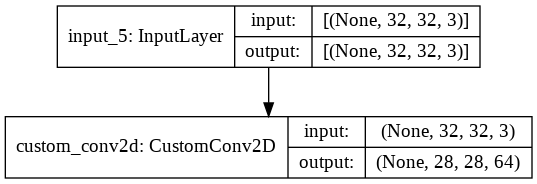

In [ ]:
input=tf.keras.layers.Input(input_shape)
x=CustomConv2D(filters=64)
x=x(input)
x.trainable=False

model=tf.keras.models.Model(input,x)

model.summary()
plot_model(model,show_shapes=True)


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 64)        4864      
Total params: 4,864
Trainable params: 4,864
Non-trainable params: 0
_________________________________________________________________


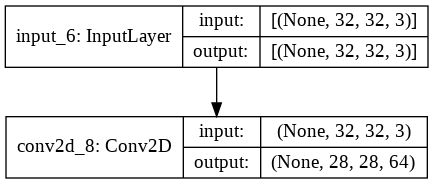

In [ ]:
input=tf.keras.layers.Input(input_shape)
x=tf.keras.layers.Conv2D(64,5)(input)
model=tf.keras.models.Model(input,x)
model.summary()
plot_model(model,show_shapes=True)

In [ ]:
class Conv2DTiledKernel_without_groups(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, multiplies,**kwargs):
        self.filters = filters
        self.kernel_size = kernel_size
        self.multiplies = multiplies
        super(Conv2DTiledKernel_without_groups, self).__init__(**kwargs)
    def build(self, input_shape):
        shape = list(self.kernel_size) + [input_shape[-1], self.filters]
        self.kernel = self.add_weight(name='kernel', shape=shape,
                                      initializer='glorot_uniform')
        self.kernel._trainable_weights=False
        super(Conv2DTiledKernel_without_groups, self).build(input_shape)
    def call(self, x):
        mult = list(self.multiplies) + [1,1]
        kernel_tiled = tf.tile(self.kernel, mult)
        kernel_tiled.trainable=False
        return tf.keras.backend.conv2d(x, kernel_tiled)
    #def compute_output_shape(self, input_shape):
     #   return input_shape[:-1] + (self.filters,)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_tiled_kernel_without_ (None, 23, 28, 64)        4800      
Total params: 4,800
Trainable params: 4,800
Non-trainable params: 0
_________________________________________________________________


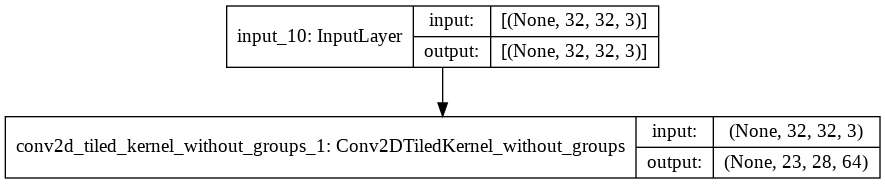

In [ ]:
img = tf.keras.layers.Input(shape=(32, 32, 3))
output = Conv2DTiledKernel_without_groups(64, [5,5], [2,1])(img)
model = tf.keras.models.Model(inputs=img, outputs=output)
model.summary()
plot_model(model,show_shapes=True)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_tiled_kernel_without_ (None, 24, 30, 64)        1728      
Total params: 1,728
Trainable params: 1,728
Non-trainable params: 0
_________________________________________________________________


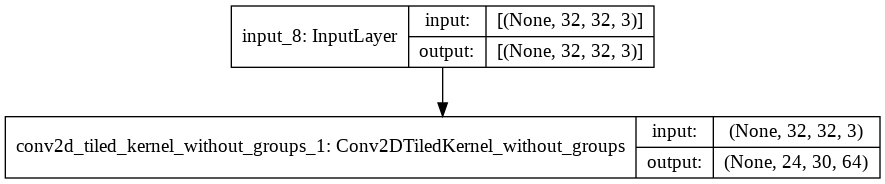

In [ ]:
img = tf.keras.layers.Input(shape=(32, 32, 3))
output = Conv2DTiledKernel_without_groups(64, [3,3], [3,1])(img)
model = tf.keras.models.Model(inputs=img, outputs=output)
model.summary()
plot_model(model,show_shapes=True)

https://stackoverflow.com/questions/54093950/how-to-experiment-with-custom-2d-convolution-kernels-in-keras

# custom kernel sharing with groups

https://stackoverflow.com/questions/66003585/creating-custom-conv2d-layer-in-keras-with-several-hard-coded-filters

#normal convolution
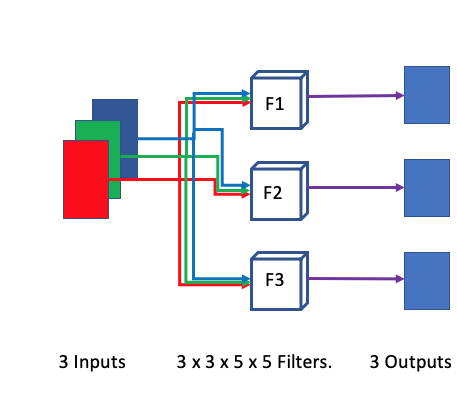

# group convolution with groups=4
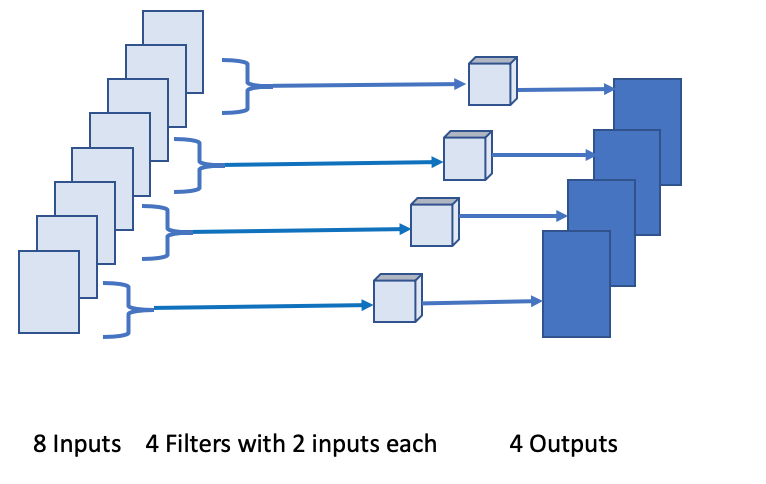

In [ ]:
class Conv2DTiledKernel_with_groups(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, multiplies, groups,**kwargs):
        self.filters = filters
        self.kernel_size = kernel_size
        self.multiplies = multiplies
        self.groups=groups
        super(Conv2DTiledKernel_with_groups, self).__init__(**kwargs)
    def build(self, input_shape):
        shape = list(self.kernel_size) + [input_shape[-1]//self.groups, self.filters//self.groups]
        self.kernel = self.add_weight(name='kernel', shape=shape,
                                      initializer='glorot_uniform')
        self.kernel._trainable_weights=False
        super(Conv2DTiledKernel_with_groups, self).build(input_shape)
    def call(self, x):
        mult = list(self.multiplies) + [1, self.groups]
        kernel_tiled = tf.tile(self.kernel, mult)
        return tf.keras.backend.conv2d(x, kernel_tiled)
    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (self.filters,)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_tiled_kernel_with_gro (None, 23, 28, 63)        525       
Total params: 525
Trainable params: 525
Non-trainable params: 0
_________________________________________________________________


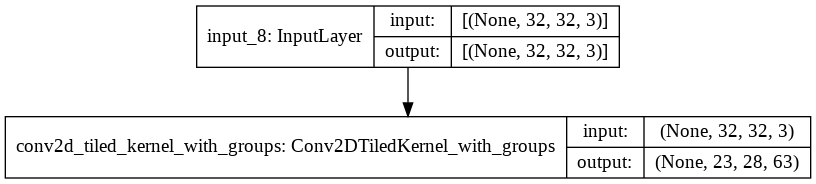

In [ ]:
img = tf.keras.layers.Input(shape=(32, 32, 3))
output = Conv2DTiledKernel_with_groups(64, [5,5], [2,1],3)(img)
model = tf.keras.models.Model(inputs=img, outputs=output)
model.summary()
plot_model(model,show_shapes=True)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_tiled_kernel_with_gro (None, 24, 30, 63)        189       
Total params: 189
Trainable params: 189
Non-trainable params: 0
_________________________________________________________________


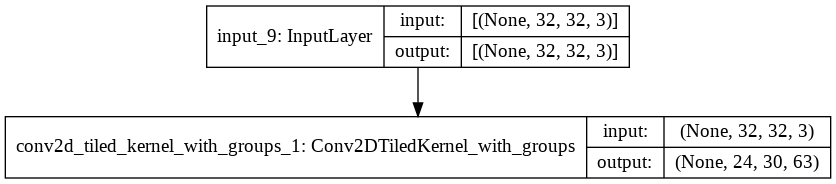

In [ ]:
img = tf.keras.layers.Input(shape=(32, 32, 3))
output = Conv2DTiledKernel_with_groups(64, [3,3], [3,1],3)(img)
model = tf.keras.models.Model(inputs=img, outputs=output)
model.summary()
plot_model(model,show_shapes=True)

# mobilenet with the custom kernel with groups to check the performance

In [ ]:

def ManishNet(input_shape, n_classes):
  """
  Manish's variation of MobileNetV1
  """
  
  def mobilenet_block(x, f, s=1):
    x = tf.keras.layers.DepthwiseConv2D(3, strides=s, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(f, 1, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x =tf.keras.layers.Activation('relu')(x)
    return x
    
    
  input = tf.keras.layers.Input(input_shape)

  x = Conv2DTiledKernel_with_groups(64, [5,5], [5,1],3)(input)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  x = mobilenet_block(x, 64)
  x = mobilenet_block(x, 128, 2)
  x = mobilenet_block(x, 128)

  x = mobilenet_block(x, 256, 2)
  x = mobilenet_block(x, 256)

  x = mobilenet_block(x, 512, 2)
  for _ in range(5):
    x = mobilenet_block(x, 512)

  x = mobilenet_block(x, 1024, 2)
  x = mobilenet_block(x, 1024)
  
  x = tf.keras.layers.GlobalAvgPool2D()(x)
  # x = tf.keras.layers.AveragePooling2D()(x)
  
  output = tf.keras.layers.Dense(n_classes, activation='softmax')(x)
  
  model = tf.keras.models.Model(input, output)
  return model


In [ ]:
model=ManishNet(input_shape, n_classes=10)
model.summary()

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        [(None, 33, 33, 3)]       0         
_________________________________________________________________
conv2d_tiled_kernel_with_gro (None, 9, 29, 63)         525       
_________________________________________________________________
batch_normalization_101 (Bat (None, 9, 29, 63)         252       
_________________________________________________________________
activation_101 (Activation)  (None, 9, 29, 63)         0         
_________________________________________________________________
depthwise_conv2d_49 (Depthwi (None, 9, 29, 63)         630       
_________________________________________________________________
batch_normalization_102 (Bat (None, 9, 29, 63)         252       
_________________________________________________________________
activation_102 (Activation)  (None, 9, 29, 63)         0  


## **comparing parameters**

```
original
Total params: 3,250,058
Trainable params: 3,228,170
Non-trainable params: 21,888
```
```
with Hlac
Total params: 3,248,046
Trainable params: 3,226,222
Non-trainable params: 21,824
```
```
with group conv
Total params: 3,249,574
Trainable params: 3,227,682
Non-trainable params: 21,892
```
```
with custom kernel with group sharing
Total params: 3,252,229
Trainable params: 3,230,217
Non-trainable params: 22,012
```
**Had a problem with getting correct problems**
```
with improved point wise convolutions
Total params: 309,616
Trainable params: 305,122
Non-trainable params: 4,494
```


```
wrong method
Total params: 283,684
Trainable params: 278,150
Non-trainable params: 5,534
```

In [ ]:
class CustomConv2D(tf.keras.layers.Layer):
    def __init__(self, filters,groups, **kwargs):
        self.filters = filters
        self.kernel_size = (3, 3)
        self.groups=groups
        super(CustomConv2D, self).__init__(**kwargs)

    def build(self, input_shape):
        # only have a 3x3 kernel
        #input_shape=tf.convert_to_tensor(input_shape)
        #input_shape=tf.cast(input_shape,tf.int32)

        shape = list(self.kernel_size + (input_shape[-1]// self.groups, self.filters // self.groups))
        self.kernel = self.add_weight(name='kernel', shape=shape,
                                     initializer='glorot_uniform')
        self.kernel=tf.tile(self.kernel,[1,1,1,self.groups])
        super(CustomConv2D, self).build(input_shape)
        
        # Make sure self.filters is divisible by self.groups
        #input_shape=tf.cast(input_shape,tf.int32)
        #kernel_shape = self.kernel_size + (input_shape // self.groups, self.filters // self.groups)
        # Filters for a single group
        #self.kernel_base = self.add_weight(
         #   name='kernel',
          #  shape=kernel_shape,
           # initializer='glorot_uniform')
        # Tile filters for the rest of groups
        #self.kernel = tf.tile(self.kernel_base, [1, 1, 1, self.groups])
        super(CustomConv2D, self).build(input_shape)

    def call(self, x):
        # duplicate rows 0 and 2
        #dup_rows = tf.stack([self.kernel[0]]*3 + [self.kernel[2]]*4, axis=0)
        # duplicate cols 0 and 2
        #dup_cols = tf.stack([dup_rows[:,0]]*3 +  [dup_rows[:,2]]*4, axis=1)
        self.kernel=tf.tile(self.kernel,[self.groups,1,1,1])
        # having a 5x5 kernel now
        return tf.keras.backend.conv2d(x, self.kernel)

    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (self.filters,)

In [ ]:
input_shape=(33,33,3)

In [ ]:
input=tf.keras.layers.Input(input_shape)
x=CustomConv2D(filters=66,groups=3)(input_shape)
#x=x(input_shape)
model=tf.keras.models.Model(input,x)
model.summary()
plot_model(model,show_shapes=True)


TypeError: ignored

In [ ]:
tf.cast(input_shape,tf.int32)//3

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([10, 10,  1], dtype=int32)>

In [ ]:
"""def IPC_block(x, f,alpha,k):
    x = tf.keras.layers.DepthwiseConv2D(3, strides=1, padding='same')(x)
    y=x.shape
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    seed=np.random.uniform(size=y[-1],low=-1,high=1)
    seed=np.reshape(seed,(y[-1],1,1))
    seed=tf.convert_to_tensor(seed)
    #print(seed.dtype)
    #
    alpha=tf.cast(alpha,'float64')
    #print(alpha.dtype)
    #scale
    #q=alpha*w
    #alpha= tf.reshape(alpha,[1,seed.shape])
    #print(alpha.shape)
    #q=tf.nn.conv1d(seed,alpha,stride=1,padding='SAME')
    #q=q.astype('float32')
    #print(q.dtype)
    #print(q.shape)
    z=tf.tensordot(alpha,seed,axes=0)
    z=z[None,:,:,:]
    beta=tf.keras.layers.Conv2D(f, k, strides=1, padding='same')(z)
   # print("first",beta.shape)
    _,x11,y1,z1=beta.shape
    beta=tf.reshape(beta,(y[1],x11*y1*z1//(y[1]),1))
    #print(beta.shape)
    x2=tf.keras.layers.Conv2D(1,1,strides=1,padding='valid')(x)
    #print("first_2",x2.shape)
    _,x12,y2,z2=x2.shape
    x2=tf.reshape(x2,(y[1],x12*y2*z2//(y[1]),1))
    #print(x2.shape)
    y1 = tf.keras.layers.Concatenate(axis=1)([beta, x2])
     #https://stackoverflow.com/questions/60486437/add-none-dimension-in-tensorflow-2-0
    y1=y1[None,:,:,:]
   
    #print("output",y1.shape)
    #x = tf.keras.layers.Conv2D(f, 1, strides=1, padding='same')(x)

    x = tf.keras.layers.BatchNormalization()(y1)
    x =tf.keras.layers.Activation('relu')(x)
    return x
    """

'def IPC_block(x, f,alpha,k):\n    x = tf.keras.layers.DepthwiseConv2D(3, strides=1, padding=\'same\')(x)\n    y=x.shape\n    x = tf.keras.layers.BatchNormalization()(x)\n    x = tf.keras.layers.Activation(\'relu\')(x)\n    seed=np.random.uniform(size=y[-1],low=-1,high=1)\n    seed=np.reshape(seed,(y[-1],1,1))\n    seed=tf.convert_to_tensor(seed)\n    #print(seed.dtype)\n    #\n    alpha=tf.cast(alpha,\'float64\')\n    #print(alpha.dtype)\n    #scale\n    #q=alpha*w\n    #alpha= tf.reshape(alpha,[1,seed.shape])\n    #print(alpha.shape)\n    #q=tf.nn.conv1d(seed,alpha,stride=1,padding=\'SAME\')\n    #q=q.astype(\'float32\')\n    #print(q.dtype)\n    #print(q.shape)\n    z=tf.tensordot(alpha,seed,axes=0)\n    z=z[None,:,:,:]\n    beta=tf.keras.layers.Conv2D(f, k, strides=1, padding=\'same\')(z)\n   # print("first",beta.shape)\n    _,x11,y1,z1=beta.shape\n    beta=tf.reshape(beta,(y[1],x11*y1*z1//(y[1]),1))\n    #print(beta.shape)\n    x2=tf.keras.layers.Conv2D(1,1,strides=1,padding=\'val